In [2]:
# import libraries we need
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

## Datasets

In [3]:
# Read the dataset
df = pd.read_csv('creditcard.csv')
pd.set_option('display.max_columns', None)

## Data Pre-Processing

### Imblanced piecahrt

([<matplotlib.patches.Wedge at 0x1eb8b4fd310>,
 [Text(1.0999838009225849, 0.005969732649226358, 'Fraud'),
  Text(-1.0999838004750038, -0.005969815120018522, 'Normal')],
 [Text(0.5999911641395917, 0.003256217808668922, '0.2%'),
  Text(-0.5999911638954565, -0.003256262792737375, '99.8%')])

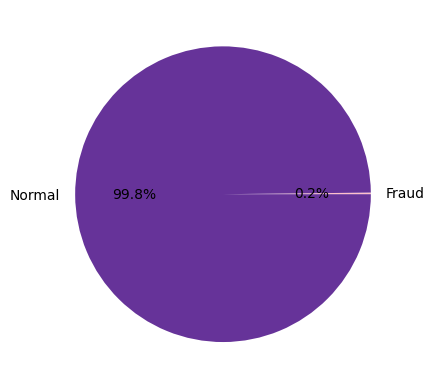

In [4]:
# Imblanced piecahrt
CheckBalanced = df['Class'].value_counts()
Fraud = len(df[df['Class']==1])
UnFraud = len(df[df['Class']==0])
fig, ax = plt.subplots()

sizes = [Fraud,UnFraud]
sizes
labels = 'Fraud','Normal'
ax.pie(sizes, labels=labels,autopct='%1.1f%%',colors=['pink','rebeccapurple'])

### NA Check

In [4]:
# NACheck
NACheck = df.apply(lambda x: x.isna().sum(), axis=1)
NACheck.describe()

count    284807.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

### Missing data:
There are **no missing values** in the dataset at all.
### Imbalanced data:
As we can see, the data we get is **seriously imbalanced**.

### Correlation Heatmap

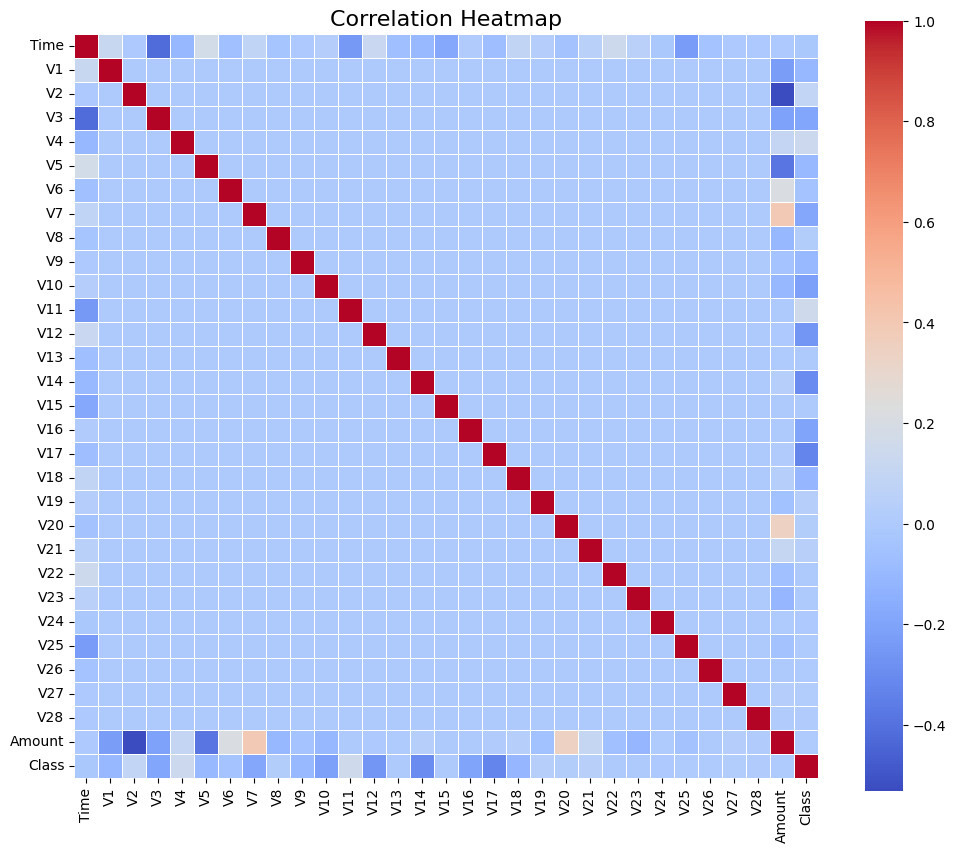

In [5]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True, square=True, linewidths=0.5)

# Add title
plt.title("Correlation Heatmap", fontsize=16)

# Display the heatmap
plt.show()

### Feature Selection
Choose Which feature is useful for the transaction Classification using correlation and ANOVA

#### Correlation

In [6]:
# Compute Correlation with the target column 'Class'
correlation = df.corrwith(df['Class']).sort_values(ascending=False).to_frame()
correlation.columns = ['corr']  

# Select features with significant positive correlation (> 0.1)
PositiveCorrelation = correlation[correlation['corr'] > 0.1]

# Select features with significant negative correlation (< -0.1)
NegativeCorrelation = correlation[correlation['corr'] < -0.1]

# Combine positively and negatively correlated features
FeatureTemp = NegativeCorrelation.index.append(PositiveCorrelation.index)

# Create a subset of the DataFrame with these features, keeping 'Class' column at the end
FilterSelectionColumn = df[FeatureTemp]  # Subset DataFrame with selected features
LastColumn = FilterSelectionColumn.pop('Class')  # Remove 'Class' column
FilterSelectionColumn.insert(len(FeatureTemp) - 1, 'Class', LastColumn)  # Add 'Class' back at the end
correlation

,corr
Class,1.000000
V11,0.154876
V4,0.133447
V2,0.091289
V21,0.040413
V19,0.034783
V20,0.020090
V8,0.019875
V27,0.017580
V28,0.009536


#### ANOVA

In [7]:
# Prepare features and target for ANOVA
features = df.drop('Class', axis=1)  # Drop 'Class' to isolate features
target = df['Class']  # Target variable

# Use SelectKBest with ANOVA (f_classif) to score features
best_features = SelectKBest(score_func=f_classif, k='all')  # Evaluate all features
fit = best_features.fit(features, target)  # Fit the ANOVA model

# Store ANOVA scores in a DataFrame for easier interpretation
featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['ANOVA Score'])
featureScores

,ANOVA Score
Time,43.252998
V1,2955.668946
V2,2393.401678
V3,11014.508305
V4,5163.832114
V5,2592.357929
V6,543.510578
V7,10349.605408
V8,112.548287
V9,2746.600273


#### Feature Selection
Select the features where both ANOVA and correlation significantly contribute to the classification process.

In [8]:
# Combine Correlation and ANOVA results
# Merge correlation and ANOVA scores into a single DataFrame
combined_scores = featureScores.merge(correlation, left_index=True, right_index=True)

# Filter features where both correlation and ANOVA score thresholds are satisfied
# (ANOVA Score > threshold, correlation > 0.1 or < -0.1)
anova_threshold = 2000  # Example threshold for ANOVA scores
selected_features = combined_scores[
    (combined_scores['corr'].abs() > 0.1) & (combined_scores['ANOVA Score'] > anova_threshold)
]

# Subset the original DataFrame with the selected features
final_selected_features = selected_features.index.tolist()  # Get the names of selected features
final_df = df[final_selected_features + ['Class']]  # Include 'Class' column for classification tasks

# Display the selected features and scores
print("Selected Features Based on Correlation and ANOVA:")
print(selected_features)

# Final filtered DataFrame for model training or evaluation
print("\nFinal DataFrame with Selected Features:")
final_df

Selected Features Based on Correlation and ANOVA:
      ANOVA Score      corr
V1    2955.668946 -0.101347
V3   11014.508305 -0.192961
V4    5163.832114  0.133447
V7   10349.605408 -0.187257
V10  14057.979985 -0.216883
V11   6999.355047  0.154876
V12  20749.822361 -0.260593
V14  28695.547788 -0.302544
V16  11443.349428 -0.196539
V17  33979.168593 -0.326481
V18   3584.380605 -0.111485

Final DataFrame with Selected Features:


,V1,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18,Class
0,-1.359807,2.536347,1.378155,0.239599,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
1,1.191857,0.166480,0.448154,-0.078803,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0
2,-1.358354,1.773209,0.379780,0.791461,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0
3,-0.966272,1.792993,-0.863291,0.237609,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0
4,-1.158233,1.548718,0.403034,0.592941,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0
...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,-9.834783,-2.066656,-4.918215,4.356170,-1.593105,2.711941,4.626942,1.107641,1.991691,0.510632,0
284803,-0.732789,2.035030,-0.738589,0.024330,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,0
284804,1.919565,-3.249640,-0.557828,-0.296827,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0.395652,0
284805,-0.240440,0.702510,0.689799,-0.686180,-0.399126,-1.933849,-0.962886,0.449624,-0.608577,0.509928,1.113981,0


## Modeling and Analysis

### Model Evaluation

In [9]:
def evaluate_model(model, X_test, y_test, model_name):
    # Predictions and probabilities
    if hasattr(model, "predict_proba"):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred = model.predict(X_test)
        y_prob = model.decision_function(X_test)
    else:
        y_prob = model.predict(X_test)
        y_pred = (y_prob > 0.3).astype(int)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Print metrics
    print(f"=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(recall_vals, precision_vals, label="Precision-Recall curve")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.show()

    return acc, recall, precision, f1, sensitivity, specificity

### Oversample and Undersample then split the data

Class distribution after resampling: Counter({0: 3940, 1: 1970})


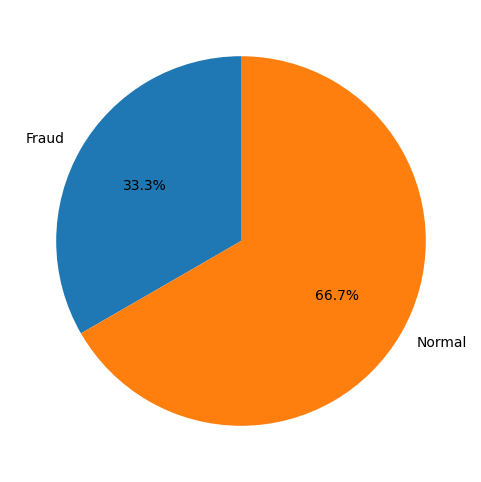

In [12]:
# Load the dataset
X = final_df.drop('Class', axis=1)
y = final_df['Class']

# Split data into training and test sets
X_train_original, X_test, y_train_original, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)

# Encode the target variable (Class) using LabelEncoder
lab = preprocessing.LabelEncoder()  
features = X_train_original  
target = y_train_original  
target = lab.fit_transform(target)  

# Define over-sampling and under-sampling strategies
# SMOTE generates synthetic samples for the minority class
over = SMOTE(sampling_strategy=0.5)  
# RandomUnderSampler reduces the size of the majority class
under = RandomUnderSampler(sampling_strategy=0.1)  

# Create a pipeline to apply under-sampling and then over-sampling
steps = [('under', under), ('over', over)] 
pipeline = Pipeline(steps=steps)  

# Resample the dataset
features_resampled, target_resampled = pipeline.fit_resample(features, target)

# Print the class distribution after resampling
print("Class distribution after resampling:", Counter(target_resampled))

# Use the oversample/undersample data to train
X_train, y_train = features_resampled, target_resampled

# Resampled Pie Chart
new_sizes = [Counter(target_resampled)[1],Counter(target_resampled)[0]]
new_labels = 'Fraud','Normal'
# ax.pie(new_sizes, labels=new_labels,autopct='%1.1f%%',colors=['green','red'])
plt.figure(figsize=(6, 6))
plt.pie(new_sizes, labels=new_labels, autopct='%1.1f%%', startangle=90)
plt.show()

### SVM(Support Vector Machines)

=== SVM ===
Accuracy: 0.9789
Recall: 0.9286
Precision: 0.0707
F1-Score: 0.1314
Sensitivity: 0.9286
Specificity: 0.9790

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.93      0.13        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962



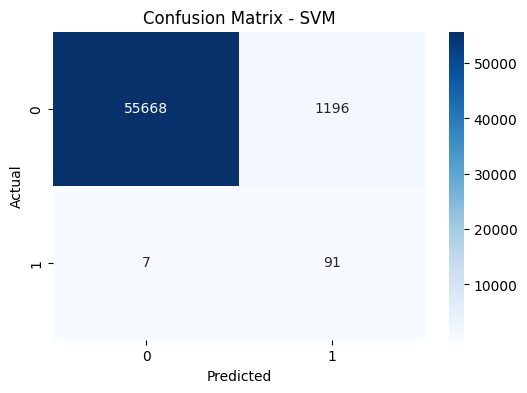

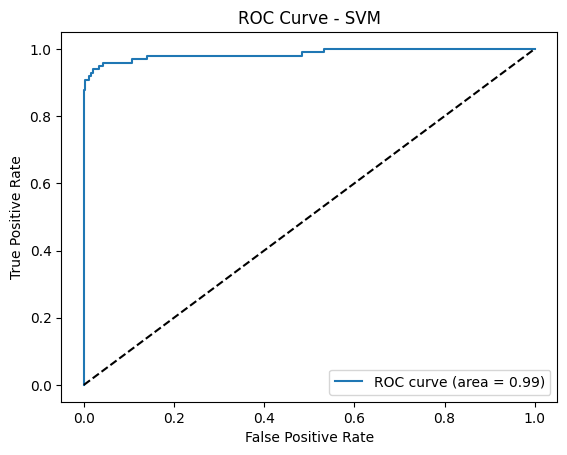

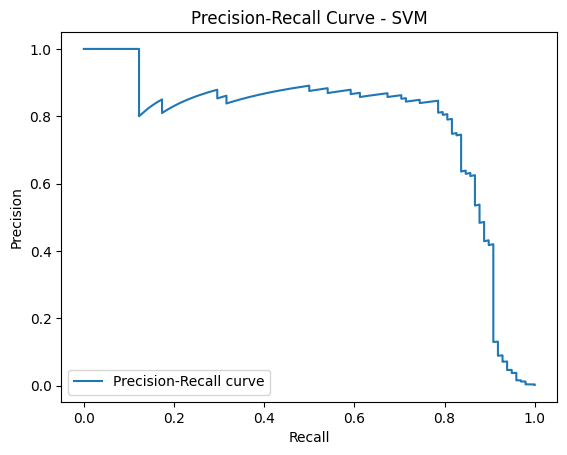

(0.9788806572802922,
 0.9285714285714286,
 0.0707070707070707,
 0.13140794223826716,
 0.9285714285714286,
 0.9789673607203151)

In [11]:
# Create a pipeline for scaling and training LinearSVC
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes features by removing the mean and scaling to unit variance
    ('svm', SVC(kernel="linear", class_weight="balanced", max_iter=10000))  # LinearSVC with balanced class weights
])

# Fit the model
svm_pipeline.fit(X_train, y_train)

# Evaluate the model
evaluate_model(svm_pipeline, X_test, y_test, "SVM")

### Random Forest

=== Random Forest ===
Accuracy: 0.9965
Recall: 0.9082
Precision: 0.3179
F1-Score: 0.4709
Sensitivity: 0.9082
Specificity: 0.9966

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.32      0.91      0.47        98

    accuracy                           1.00     56962
   macro avg       0.66      0.95      0.73     56962
weighted avg       1.00      1.00      1.00     56962



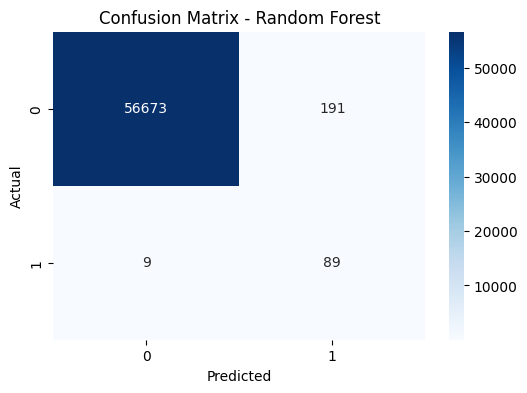

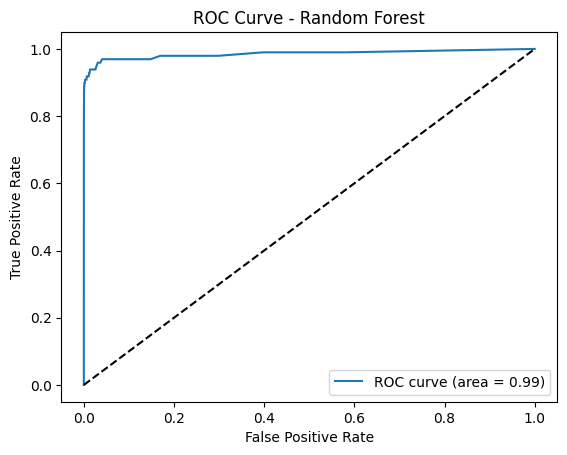

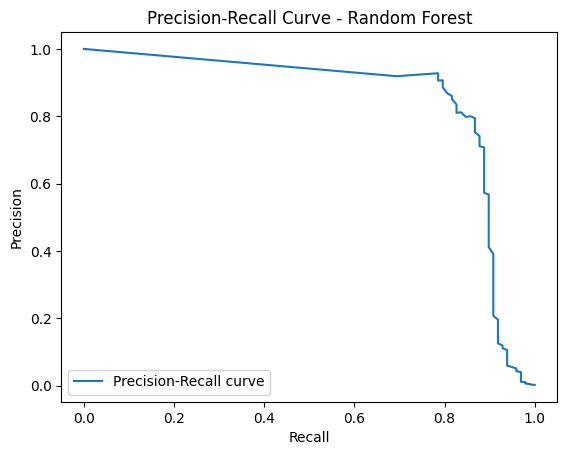

(0.9964888873283944,
 0.9081632653061225,
 0.31785714285714284,
 0.4708994708994709,
 0.9081632653061225,
 0.9966411086100169)

In [12]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=27)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Random Forest")

### XGBoost

=== XGBoost ===
Accuracy: 0.9773
Recall: 0.9082
Precision: 0.0648
F1-Score: 0.1209
Sensitivity: 0.9082
Specificity: 0.9774

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



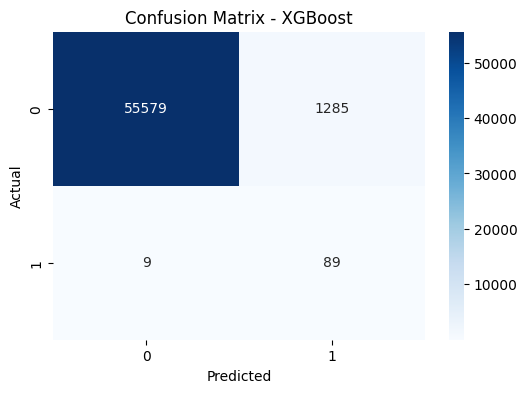

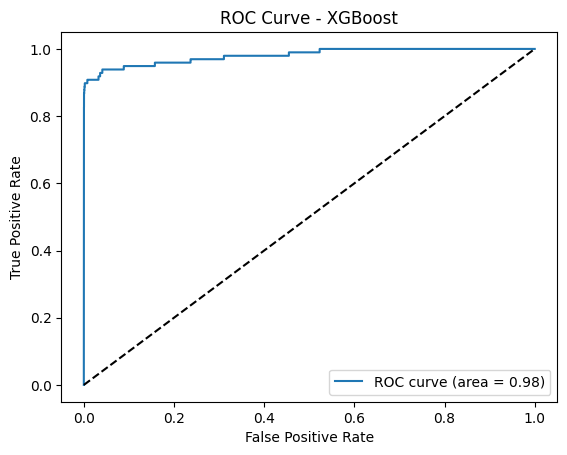

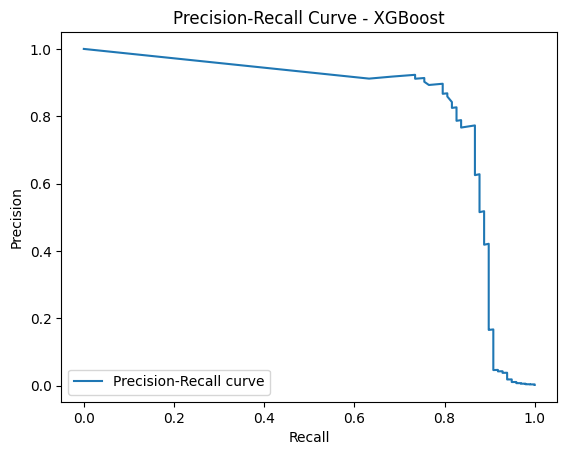

(0.9772831010147116,
 0.9081632653061225,
 0.06477438136826782,
 0.12092391304347824,
 0.9081632653061225,
 0.9774022228474958)

In [13]:
ratio = float(y_train_original.value_counts()[0]) / y_train_original.value_counts()[1]
xgb_model = XGBClassifier(scale_pos_weight=ratio, random_state=27)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")

### Neural Network

Epoch 1/100
148/148 [==============================] - 2s 6ms/step - loss: 0.0238 - accuracy: 0.9573 - val_loss: 0.0301 - val_accuracy: 0.8519
Epoch 2/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0104 - accuracy: 0.9731 - val_loss: 0.0339 - val_accuracy: 0.8613
Epoch 3/100
148/148 [==============================] - 1s 3ms/step - loss: 0.0091 - accuracy: 0.9742 - val_loss: 0.0205 - val_accuracy: 0.8816
Epoch 4/100
148/148 [==============================] - 0s 3ms/step - loss: 0.0084 - accuracy: 0.9750 - val_loss: 0.0170 - val_accuracy: 0.8993
Epoch 5/100
148/148 [==============================] - 1s 3ms/step - loss: 0.0076 - accuracy: 0.9759 - val_loss: 0.0188 - val_accuracy: 0.8714
Epoch 6/100
148/148 [==============================] - 0s 3ms/step - loss: 0.0070 - accuracy: 0.9786 - val_loss: 0.0199 - val_accuracy: 0.8866
Epoch 7/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0064 - accuracy: 0.9780 - val_loss: 0.0203 - val_accuracy: 0.8900

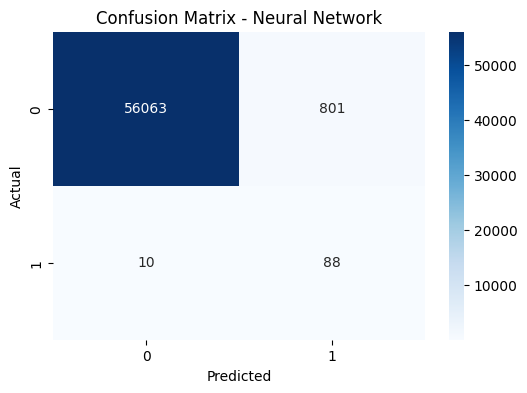

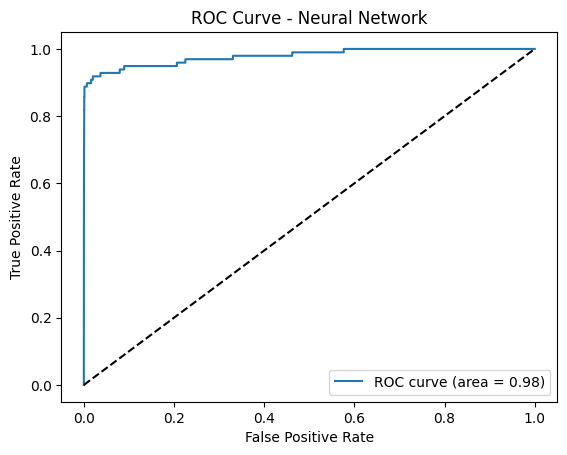

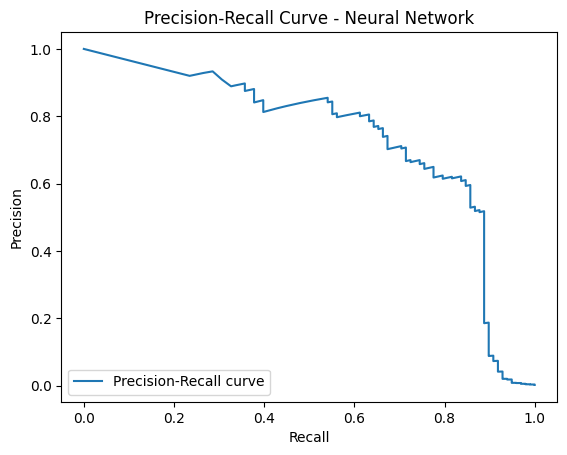

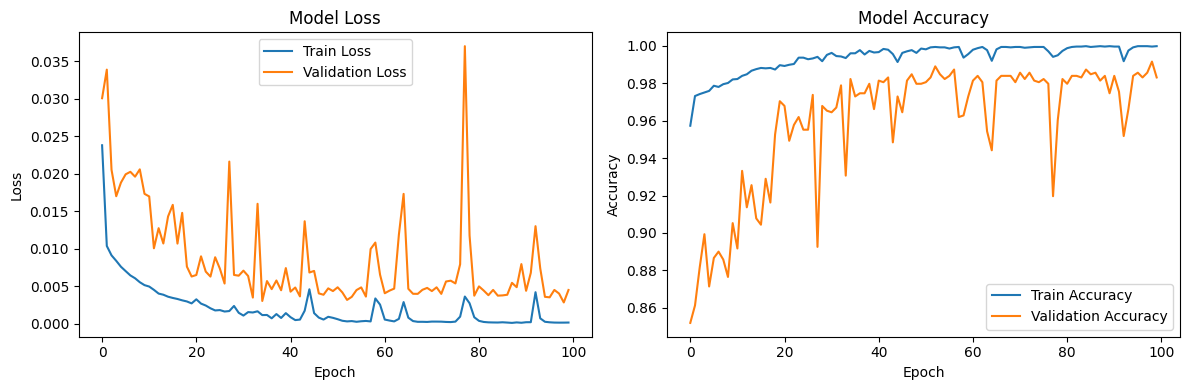

In [14]:
n_samples = len(y_train)
n_positive = sum(y_train)
ratio = (n_samples - n_positive) / n_positive
class_weight = {0: 1, 1: ratio}

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

tf_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=focal_loss(),
              metrics=['accuracy'])

history = tf_model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.2,
                    class_weight=class_weight,
                    verbose=1,
                    )

evaluate_model(tf_model, X_test, y_test, "Neural Network")

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()